In [28]:
%tensorflow_version 1.x
import tensorflow as tf

In [29]:
print(tf.__version__)

1.15.2


In [30]:
import os
import glob
import cv2
import tarfile
import numpy as np
from urllib import request
from google.colab import drive
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from sklearn.decomposition import PCA
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score

In [50]:
import keras
from keras.engine import  Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from keras_vggface.vggface import VGGFace
from google.colab import drive
from keras import models
from keras.utils import to_categorical

from PIL import Image
from numpy import asarray
from keras.optimizers import SGD, Adam

In [31]:
!pip install keras_vggface

In [32]:
from keras_vggface.vggface import VGGFace
 
# Based on VGG16 architecture -> old paper(2015)


In [33]:
# create directory
base_path = "/content/sample/TL_DataSet/"

if not os.path.isdir(base_path):
  os.makedirs(base_path)

vgg_face_dataset_url = "http://www.robots.ox.ac.uk/~vgg/data/vgg_face/vgg_face_dataset.tar.gz"

if os.path.isfile(base_path+"vgg_face_dataset.tar.gz"):
  print("vgg_face_dataset.tar.gz already exists in the folder {}".format(base_path))
  with tarfile.open(os.path.join(base_path, "vgg_face_dataset.tar.gz")) as f:
    f.extractall(os.path.join(base_path))
else:
  print("Downloading file vgg_face_dataset.tar.gz from {}".format(vgg_face_dataset_url))
  # download/write
  with request.urlopen(vgg_face_dataset_url) as r, open(os.path.join(base_path, "vgg_face_dataset.tar.gz"), 'wb') as f:
    f.write(r.read())
    # extract
  with tarfile.open(os.path.join(base_path, "vgg_face_dataset.tar.gz")) as f:
    f.extractall(os.path.join(base_path))

trained_haarcascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"

if os.path.isfile(base_path+"haarcascade_frontalface_default.xml"):
  print("haarcascade_frontalface_default.xml already exists in the folder {}".format(base_path))
else:
  # download/write
  print("Downloading file haarcascade_frontalface_default.xml from {}".format(trained_haarcascade_url))
  with request.urlopen(trained_haarcascade_url) as r, open(os.path.join(base_path, "haarcascade_frontalface_default.xml"), 'wb') as f:
    f.write(r.read())



A total of four celebrities is chosen from this dataset, call them A, B, C and D. There are certain constraints to be fulfilled between these celebrities in order to classify them at a later stage. Both person A and B must differ in terms of facial characteristics. Person C must have common features with person A, and similarly person D must share traits with person B. 


In the code below, the file names of the chosen subjects are listed and the VGG Face Dataset is searched to verify that all files are present. Here you can change the subjects. Some auxiliary variables are defined. In this case, Person A will have 30 images and Person D will have only 10.

In [34]:
subjects = ["Andy_Samberg.txt","Katy_Perry.txt", "Jesse_Eisenberg.txt",  "Zooey_Deschanel.txt"]
all_subjects = [subject for subject in sorted(os.listdir(os.path.join(base_path, "vgg_face_dataset", "files"))) if subject in subjects]
print(all_subjects)

['Andy_Samberg.txt', 'Jesse_Eisenberg.txt', 'Katy_Perry.txt', 'Zooey_Deschanel.txt']


In [35]:
subjects = ["Andy_Samberg.txt","Katy_Perry.txt", "Jesse_Eisenberg.txt",  "Zooey_Deschanel.txt"]

all_subjects = [subject for subject in sorted(os.listdir(os.path.join(base_path, "vgg_face_dataset", "files"))) if subject in subjects]
if len(subjects) != len(all_subjects):
  print('Some subject file(s) could not be found in vgg_face_dataset.')
else:
  print(all_subjects)
  
  nb_subjects = len(subjects)
  nb_images_per_subject = [30, 30, 10, 10]
  faceCascade = cv2.CascadeClassifier(os.path.join(base_path, "haarcascade_frontalface_default.xml"))


['Andy_Samberg.txt', 'Jesse_Eisenberg.txt', 'Katy_Perry.txt', 'Zooey_Deschanel.txt']


The following methods are meant to help us with downloading and storing the images from the external dataset to our own local filesystem or loading them if they have already been downloaded before. The first method ***getVGGImageData*** takes as arguments the list of local directory names for each celebrity, as well as the variables that we have defined before. 

For each subject, the method creates the respective directory. Subsequently, the corresponding text file of that celebrity in the VGG dataset is opened and the available images are being downloaded. Only images in which one face is detected by the cascade classifier for the specified parameters and template are used. There can however still be multiple identical images of a celebrity. Finally, once we have enough images of the celebrity, the images are collected in the array **images**. 

**Note**: the download can take a while, partly due to non-responding URLs that time out after a certain time.

In [36]:
def getVGGImageData(directory, nb_subjects, nb_images_per_subject, subjects):
  images = []
  for i in range(nb_subjects):
    subName = subjects[i].split('.')[0]
    writeImagePath = directory[i]
    if not os.path.exists(writeImagePath):
      os.makedirs(writeImagePath)   
    with open(os.path.join(base_path, "vgg_face_dataset", "files", subjects[i]), 'r') as f:
      lines = f.readlines()
    images_ = []
    idx = 0      
    for line in lines:
      url = line[line.find("http://"): line.find(".jpg") + 4]
      try:
        res = request.urlopen(url)
        img = np.asarray(bytearray(res.read()), dtype="uint8")
        img = cv2.imdecode(img, cv2.IMREAD_COLOR)      
        if img is not None:
          img_ = img.copy()
          # preprocess image before using Haar cascade classifier
          img_gray = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)
          # detect amount of faces
          faces = faceCascade.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
          )
          if len(faces) == 1:
            cv2.imwrite(writeImagePath+subName+'_'+str(idx)+'.jpg', img)
            images_.append(img)
            idx += 1
      except:
        pass

      if len(images_) == nb_images_per_subject[i]:
        images.append(images_)
        break
  return images

In [37]:
def loadVGGImageData(directory, nb_subjects):
  images = []
  for i in range(nb_subjects):
    images_ = []
    imageDataPaths = glob.glob(directory[i]+'/*.jpg')
    for imagesData in imageDataPaths:
      images_.append(cv2.imread(imagesData))
    
    images.append(images_)

  return images  

Finally, the methods defined earlier will be combined and invoked accordingly. We first check whether for each of the chosen subject we own a local directory of images and collect the directories in an array **directory**. 

If not all directories have been found, we invoke the ***getVGGImageData*** on **directory**. This will download the images in a fashion that was described previously. 

If we do already have downloaded these images to our local filesystem, we must simply reload them by invoking the ***loadVGGImageData*** method. 

Both cases will result in an array **images** that represents our final dataset.

In [38]:
directory = []
dl_flag = False
for sub in subjects:
  subName = sub.split('.')[0]
  subDir = base_path+subName+'/'
  if not os.path.exists(subDir):
    print("Image directory does not exist.")
    dl_flag = True
  directory.append(subDir)

if dl_flag:
  print("Creating directories and downloading images. This can take a couple of minutes...")
  images = getVGGImageData(directory, nb_subjects, nb_images_per_subject, subjects)
  print("Download complete.")  
else:
  print("Loading saved images.")
  images = loadVGGImageData(directory, nb_subjects)

Image directory does not exist.
Image directory does not exist.
Image directory does not exist.
Image directory does not exist.
Creating directories and downloading images. This can take a couple of minutes...
Download complete.


We will use Matplotlib in order to plot the images in the dataset. This can be achieved by creating a figure for each celebrity in the dataset (row) and presenting all images (columns) of that celebrity by adding a subplot to the figure. Several adjustments and additions have been made as well in order to create a consistent and neat overview of the images in the dataset.

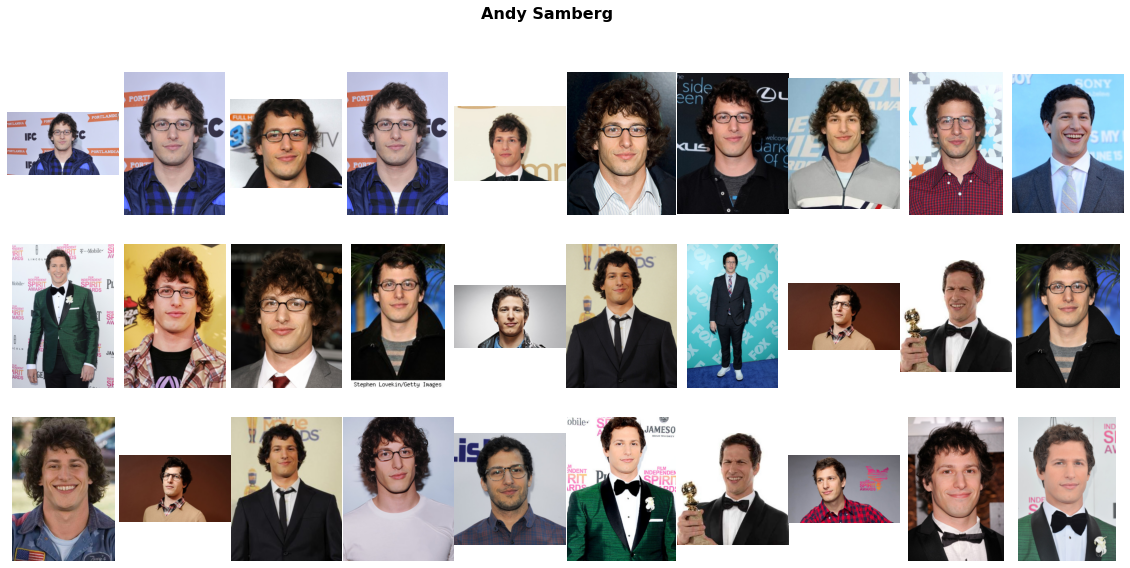

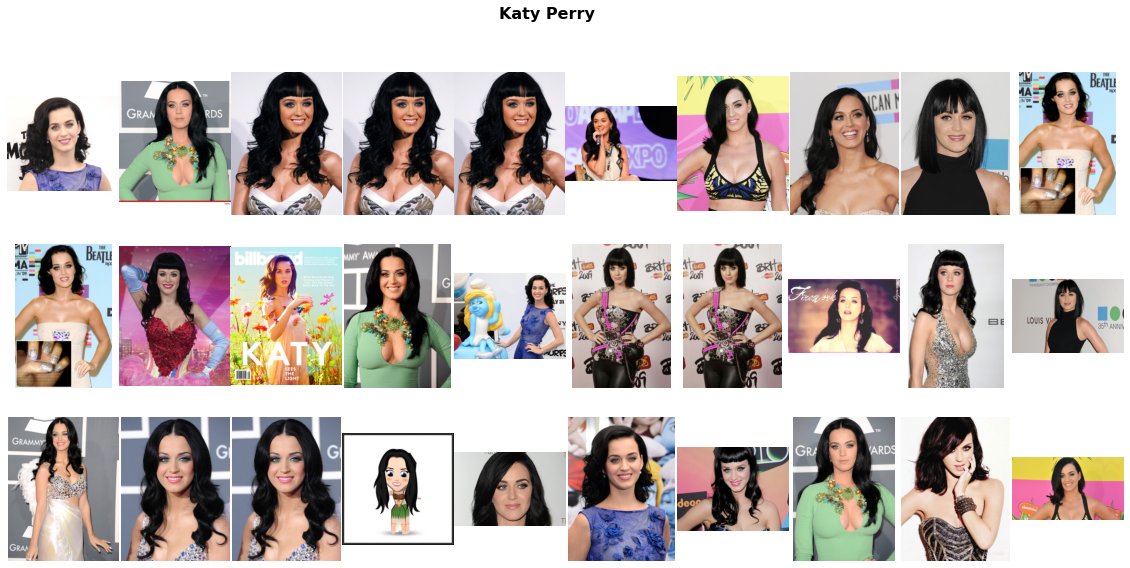

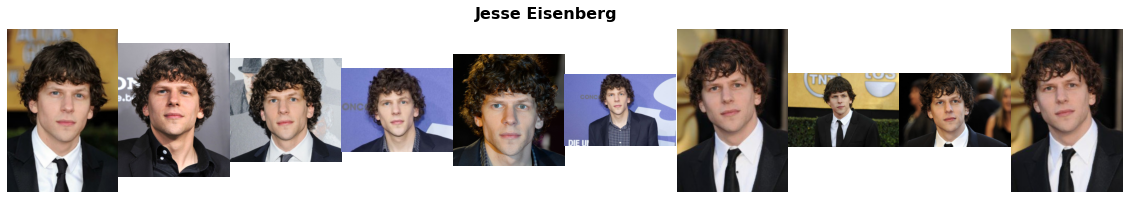

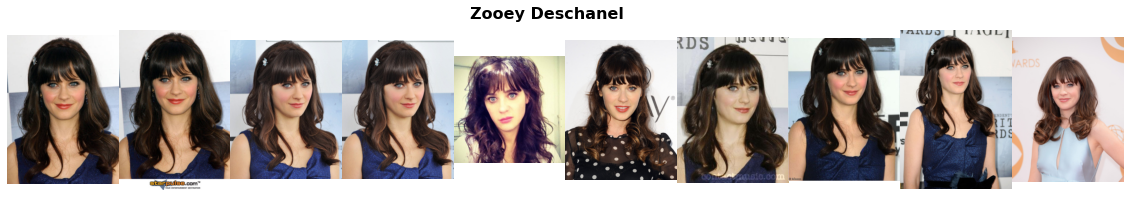

In [40]:
for i in range(nb_subjects):
  fig = plt.figure(figsize=(20,3*nb_images_per_subject[i]/10))
  fig.subplots_adjust(wspace = 0)
  subName = subjects[i][:-4].split('_')
  fig.suptitle(subName[0]+' '+subName[1], fontweight='bold', fontsize=16)
  for j in range(nb_images_per_subject[i]):
    sub = fig.add_subplot(nb_images_per_subject[i]/10, 10, j + 1)
    sub.axis('off')
    img = images[i][j]
    if np.argmax(img.shape,axis=0)==0:
      img = cv2.resize(img, (500, int(img.shape[0]/img.shape[1]*500)))
    else:
      img = cv2.resize(img, (int(img.shape[1]/img.shape[0]*500), 500))
    # opencv reads as BGR thus we have to turn into RGB for plotting with plt
    b,g,r = cv2.split(img)
    img = cv2.merge((r,g,b))
    sub.imshow(img)

In [41]:
def preprocess(img, resizeDimensions=(224,224)):
  imageCopy = img.copy()
  b,g,r = cv2.split(img)
  img = cv2.merge((r,g,b))
  img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  #detect and crop face
  #(necessary to allow simple matching afterwards)
  faces = faceCascade.detectMultiScale(
          img_gs,
          scaleFactor=1.15,
          minNeighbors=5,
          minSize=(40, 40),
          flags=cv2.CASCADE_SCALE_IMAGE)
  
  for (x, y, w, h) in [faces[0]]:
    img_face_sq = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    face_crop_gs = img_gs[y:y+h, x:x+w]
    face_crop_gs = cv2.resize(face_crop_gs, resizeDimensions)
    face_crop_col = imageCopy[y:y+h, x:x+w]
    face_crop_col = cv2.resize(face_crop_col, resizeDimensions)

  return img_face_sq,face_crop_gs, face_crop_col

Deep convolutional neural network models may take days or even weeks to train on very large datasets. Transfer learning is an approach to solve a deep learning problem that focuses on applying a stored knowledge of a problem to solve a different but related problem.

Transfer learning is flexible. It is a short-cut to re-use the model weights from pre-trained models directly, as a method of feature extraction preprocessing, and can be easily integrated into entirely new models.
Top performing models can be downloaded and used directly, or integrated into a new model for any computer vision problems.


###**Traditional Learning Vs Transfer Learning:**

*   Traditional learning is isolated and occurs purely based on specific tasks, datasets and training separate isolated models on them. No knowledge is retained which can be transferred from one model to another.
*   Whereas in transfer learning, you can leverage knowledge such as features, weights etc., from previously trained models for training newer models. It is highly useful to tackle problems where there is less data for a newer task

The process of transfer learning, follows three important questions:

**What to transfer:** We try to figure out which part of the knowledge can be transferred from the source to the target in order to improve the performance of the target task. When trying to answer this question, we try to identify which portion of knowledge is source-specific and what is common between the source and the target.

**When to transfer:** This deals with the concept of **negative transfer**. We need to be careful about when to do transfer learning and when not to. There can be scenarios where transferring knowledge for the sake of it may make matters worse than improving anything. We should aim at utilizing transfer learning to improve target task performance/results and not degrade them. 

**How to transfer:** Once the what and when have been answered, we can proceed towards identifying ways of actually transferring the knowledge across domains/tasks. This involves changes to existing algorithms and different techniques or could simply mean changing the final layers of the network (E.g: fully connected layers) suitable to the target task

###**Transfer Learning Strategies**
There are different transfer learning strategies and techniques, which can be applied based on the domain, task at hand, and the availability of data.

**Inductive Transfer learning:** In this scenario, the source and target domains are the same, yet the source and target tasks are different from each other. The algorithms try to utilize the inductive biases of the source domain to help improve the target task. Depending upon whether the source domain contains labeled data or not, this can be further divided into two subcategories, similar to multitask learning and self-taught learning, respectively.

**Unsupervised Transfer Learning:** This setting is similar to inductive transfer itself, with a focus on unsupervised tasks in the target domain. The source and target domains are similar, but the tasks are different. In this scenario, labeled data is unavailable in either of the domains.

**Transductive Transfer Learning:** In this scenario, there are similarities between the source and target tasks, but the corresponding domains are different. In this setting, the source domain has a lot of labeled data, while the target domain has none. This can be further classified into subcategories, referring to settings where either the feature spaces are different or the marginal probabilities.

**Instance transfer:** Reusing knowledge from the source domain to the target task is usually an ideal scenario. In most cases, the source domain data cannot be reused directly. Rather, there are certain instances from the source domain that can be reused along with target data to improve results. In case of inductive transfer, modifications such as AdaBoost by Dai and their co-authors help utilize training instances from the source domain for improvements in the target task.

**Feature-representation transfer:** This approach aims to minimize domain divergence and reduce error rates by identifying good feature representations that can be utilized from the source to target domains. Depending upon the availability of labeled data, supervised or unsupervised methods may be applied for feature-representation-based transfers.

**Parameter transfer:** This approach works on the assumption that the models for related tasks share some parameters or prior distribution of hyperparameters. Unlike multitask learning, where both the source and target tasks are learned simultaneously, for transfer learning, we may apply additional weightage to the loss of the target domain to improve overall performance.

**Relational-knowledge transfer:** Unlike the preceding three approaches, the relational-knowledge transfer attempts to handle non-IID data, such as data that is not independent and identically distributed. In other words, data, where each data point has a relationship with other data points; for instance, social network data utilizes relational-knowledge-transfer techniques.

All the above information is adapted from the below paper on survey on transfer learning. More information is available here: 

https://www.cse.ust.hk/~qyang/Docs/2009/tkde_transfer_learning.pdf

In the below lines of code, we seperate our test and train data sets by extracting only the facial region as our Region Of Interest (ROI) from faceCascase face detection algoirthm as described in the above sections. The extracted faces are saved into a directory for further use.

In [60]:
X_train = []
Y_train = []
X_test = []
Y_test = []
Train_img_dir = []
imageLabels = []
for i in range(0, nb_subjects):
  croppedDir = base_path+subjects[i].split('.')[0]+'_faceExtracted/'
  if (not os.path.isdir(croppedDir)):
    os.makedirs(croppedDir)
    for j in range(0 , nb_images_per_subject[i]):
      #faceImages = extract_face(images[i][j], (224,224)) 
      _,_, faceImages = preprocess(images[i][j])
      if (i <= 1 and j < 20):
        Train_img_dir.append(croppedDir+subjects[i].split('.')[0]+'_faceExtract'+str(j)+'.jpg')
        imageLabels.append(subjects[i].split('.')[0])
        X_train.append(faceImages)
        Y_train.append(i)
      else:
        #print("Appending to Test Set")
        X_test.append(faceImages)
        Y_test.append(i)
      cv2.imwrite(croppedDir+subjects[i].split('.')[0]+'_faceExtract'+str(j)+'.jpg', faceImages)
  elif(os.path.isdir(croppedDir)):
    if(len(os.listdir(croppedDir)) !=  nb_images_per_subject[i]):
      for j in range(len(os.listdir(croppedDir)) , nb_images_per_subject[i]):
        try:
          #faceImages = extract_face(images[i][j], (224,224))
           _,_, faceImages = preprocess(images[i][j])
        except:
           faceImages = cv2.resize(images[i][j],(224,224))
        if (i <= 1 and j < 20):
          #print("Appending to Train Set")
          Train_img_dir.append(croppedDir+subjects[i].split('.')[0]+'_faceExtract'+str(j)+'.jpg')
          imageLabels.append(subjects[i].split('.')[0])
          X_train.append(faceImages)
          Y_train.append(i)
        else:
          X_test.append(faceImages)
          Y_test.append(i)
        cv2.imwrite(croppedDir+subjects[i].split('.')[0]+'_faceExtract'+str(j)+'.jpg', faceImages)
    else:      
      readFaceImageDir = glob.glob(croppedDir+'*.jpg')
      for idx, faceImgInfo in enumerate(readFaceImageDir):
        imageIn = cv2.imread(faceImgInfo)
        if (i <= 1 and idx < 20):
          #print("Appending to Train Set")
          Train_img_dir.append(faceImgInfo)
          imageLabels.append(subjects[i].split('.')[0])
          X_train.append(imageIn)
          Y_train.append(i)
        else:
          #print("Appending to Test Set")
          X_test.append(imageIn)
          Y_test.append(i)

In [61]:
X_train_new = X_train
X_test_new = X_test
X_train = np.array(X_train)
Y_train_new = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

The Keras package contains a pre-trained facial detection model which has been trained over a millions of images of celebrities. We first explore this pre-trained model by importing it from the Keras package and run our train and test datasets on it directly to see the performance. The VGG Face model contains more than 2000 classes, where as our current data set contains only 2 classes. We predict the test and train data sets and then calculate the predicted score with the class labels. For the test set, we will be getting a score of 0.5 as the data set images contains 2 classes of the train set and 2 classes of look alikes but only the class labels for the first categeory. Whereas, the train set should give a score of 1, as there are only 2 classes in both datasets and labels.

In [62]:
vggface = VGGFace(model='vgg16') # or VGGFace() as default

In [63]:
from keras.engine import  Model
from keras.layers import Input

The plot below shows the classes vs the number of images corresponding to the class present in our train data sets

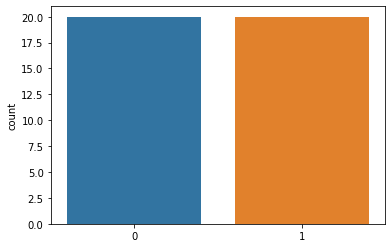

In [64]:
import seaborn as sns
sns.countplot(Y_train)
Y_train_new = Y_train

From the above pre-trained model, we were able to classify the data sets as according to the class labels. Now, we will see how we can perform transfer learning assuming our data set is new. To do so, we will need to perform the following steps 

*   We will take the same VGG Face Model and eleminate the final fully connected layer.
*   We will import the pre-trained VGG Face weights and freeze the model with those weights excluding the last four layers. This means that, only the last four layers of the model will be trainable and the weights to these layers will be updated from our train dataset.

*   We will then add our customized layers (Fully connected Layers) to give the output of only two classes corresponding to our train datasets


Here the **vgg_model.summary()** shows all the parameters of the model as trainable before freezing the initial layers





In [65]:
#Loading VGG Face dataset with vggface pre-trained weights
vgg_model = VGGFace(weights="vggface", include_top=False, input_shape=(224, 224, 3))
vgg_model.summary()


Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)     

In [66]:
#Freezing the initial convolution layers and making the finaly fully connected layers alone as trainable
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

In [69]:
nb_class = 2
hidden_dim = 1024

customVGGModel = models.Sequential()
customVGGModel.add(vgg_model)
customVGGModel.add(Flatten())
customVGGModel.add(Dense(hidden_dim, activation='relu', name='fc6'))
customVGGModel.add(BatchNormalization())
customVGGModel.add(Dense(hidden_dim, activation='relu', name='fc7'))
customVGGModel.add(BatchNormalization())
customVGGModel.add(Dropout(0.5))
customVGGModel.add(Dense(nb_class, activation='softmax', name='fc8'))

After adding our customized layers and freezing the initial convolution layers with the pre-trained weights, the number of trainable parameters reduces and can be seen below. These parameters are trained from our train dataset.

In [70]:
customVGGModel.summary()
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
X_train_tl = np.array(X_train)
Y_train_tl = np.array(Y_train)
X_test_tl = np.array(X_test)
Y_test_tl = np.array(Y_test)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_vgg16 (Model)        (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
fc6 (Dense)                  (None, 1024)              25691136  
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024)              4096      
_________________________________________________________________
fc7 (Dense)                  (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_6 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)             

In [71]:
adam = Adam(lr=0.01)
customVGGModel.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In the below line of code, we train our model with the following setting


*   Loss = binary cross entropy
*   Optimizer = Adam and Learning Rate = 0.01
*   Number of Epochs = 400


All the parameters are known as hyperparameters which are the tuning knobs of any deep learning model. By changing these parameters we can change the performance of any model (accuracy)

**Note :** Since, the number of Epochs is huge, the below training might take few minutes. 
Please be patient !!!

In [72]:
history = customVGGModel.fit(X_train_tl, Y_train_tl, epochs=200)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/200
40/40 [==============================] - 11s 283ms/step - loss: 1.3261 - accuracy: 0.6250
Epoch 2/200
40/40 [==============================] - 0s 7ms/step - loss: 1.0642 - accuracy: 0.8750
Epoch 3/200
40/40 [==============================] - 0s 7ms/step - loss: 0.3419 - accuracy: 0.9750
Epoch 4/200
40/40 [==============================] - 0s 7ms/step - loss: 0.0374 - accuracy: 0.9750
Epoch 5/200
40/40 [==============================] - 0s 7ms/step - loss: 0.1833 - accuracy: 0.9750
Epoch 6/200
40/40 [==============================] - 0s 7ms/step - loss: 6.5775e-04 - accuracy: 1.0000
Epoch 7/200
40/40 [==============================] - 0s 7ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 8/200
40/40 [==============================] - 0s 7ms/step - loss: 0.1111 - accuracy: 0.9750
Epoch 9/200
40/40 [==============================] - 0s 7ms/step - loss: 0.0809 - accuracy: 0.9750
Epoch 1

In [73]:
save_model_path = base_path+'TL_Model_Output_Weights/'
save_model_name = 'custom_vggModel_weights.h5'
if not os.path.isdir(save_model_path):
  print("No Directory to save the model weights")
  print("Creating a new diretory to save the model weights")
  os.makedirs(save_model_path)
  customVGGModel.save(save_model_path+save_model_name)
  print("SAVED MODEL TO : {}".format(save_model_name))
else:
  print("Directory to save model exists")
  if(len(os.listdir(save_model_path)) == 0):
    print("Directory is empty and saving the model !!!")
    customVGGModel.save(save_model_path+save_model_name)
    print("SAVED MODEL TO : {}".format(save_model_name))
  else:
    print("Directory is not empty and over-writing the existing model with new weights")
    customVGGModel.save(save_model_path+save_model_name)
    print("SAVED MODEL TO : {}".format(save_model_name))

No Directory to save the model weights
Creating a new diretory to save the model weights
SAVED MODEL TO : custom_vggModel_weights.h5


Here, we predict the trained model with the test data set. Our model should correctly classify the persons who are present in both train and test sets. For the persons present in test set but not in the train set, the model can assign any class randomly or assign a class whose features match closely with the unknown persons features since we haven't trained the model with any negative examples.

The probability scores for these look alike person classifications will be very low.

In [74]:
classes = customVGGModel.predict(X_test_tl)

In [75]:
print("The predicted class probablilities on the test images are :", classes)

The predicted class probablilities on the test images are : [[4.4134078e-03 9.9558663e-01]
 [1.0000000e+00 4.7457522e-32]
 [1.0000000e+00 5.0163863e-21]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.9816735e-36]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.1745389e-33]
 [1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00]
 [1.0000000e+00 3.2425211e-12]
 [1.0000000e+00 5.9728110e-27]
 [9.9999130e-01 8.6720092e-06]
 [1.0000000e+00 4.8923635e-18]
 [1.0000000e+00 1.8080777e-26]
 [9.0878321e-14 1.0000000e+00]
 [1.0000000e+00 3.5665030e-26]
 [1.0000000e+00 1.9968181e-15]
 [9.9999976e-01 2.5620099e-07]
 [1.0000000e+00 0.0000000e+00]
 [0.000000

In our current application of transfer learning, we have saved only one model. But usually when we train a model with huge data sets, we need to save the best model with low training and validation loss and high accuracy. Sometimes, we can save last three models with checkpoints. Out of these three models we can choose the best model by plotting the training accuracy and loss. The below plots show the training accuray and training loss that occured over the number of epochs during our training



In [76]:
'''if not os.path.isfile(model_weights_path):
  print("VGG Face Weights doesn't exits!!!")
  print("Downloading the weights to the folder {}".format(model_weights_path))
  !wget wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo" -O /content/sample_data/vgg_face_weights.h5 && rm -rf /tmp/cookies.txt 
else:
  print("VGG face Weights are available in the folder {}".format(model_weights_path))'''

'if not os.path.isfile(model_weights_path):\n  print("VGG Face Weights doesn\'t exits!!!")\n  print("Downloading the weights to the folder {}".format(model_weights_path))\n  !wget wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \'https://docs.google.com/uc?export=download&id=1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo\' -O- | sed -rn \'s/.*confirm=([0-9A-Za-z_]+).*/\x01\n/p\')&id=1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo" -O /content/sample_data/vgg_face_weights.h5 && rm -rf /tmp/cookies.txt \nelse:\n  print("VGG face Weights are available in the folder {}".format(model_weights_path))'

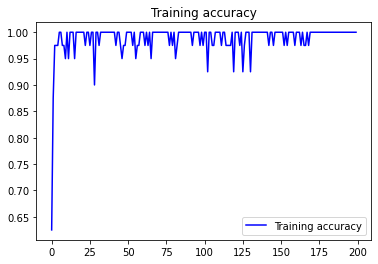

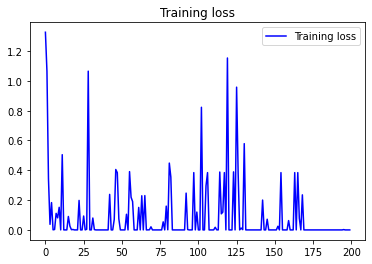

In [77]:
acc = history.history['accuracy']
loss = history.history['loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()


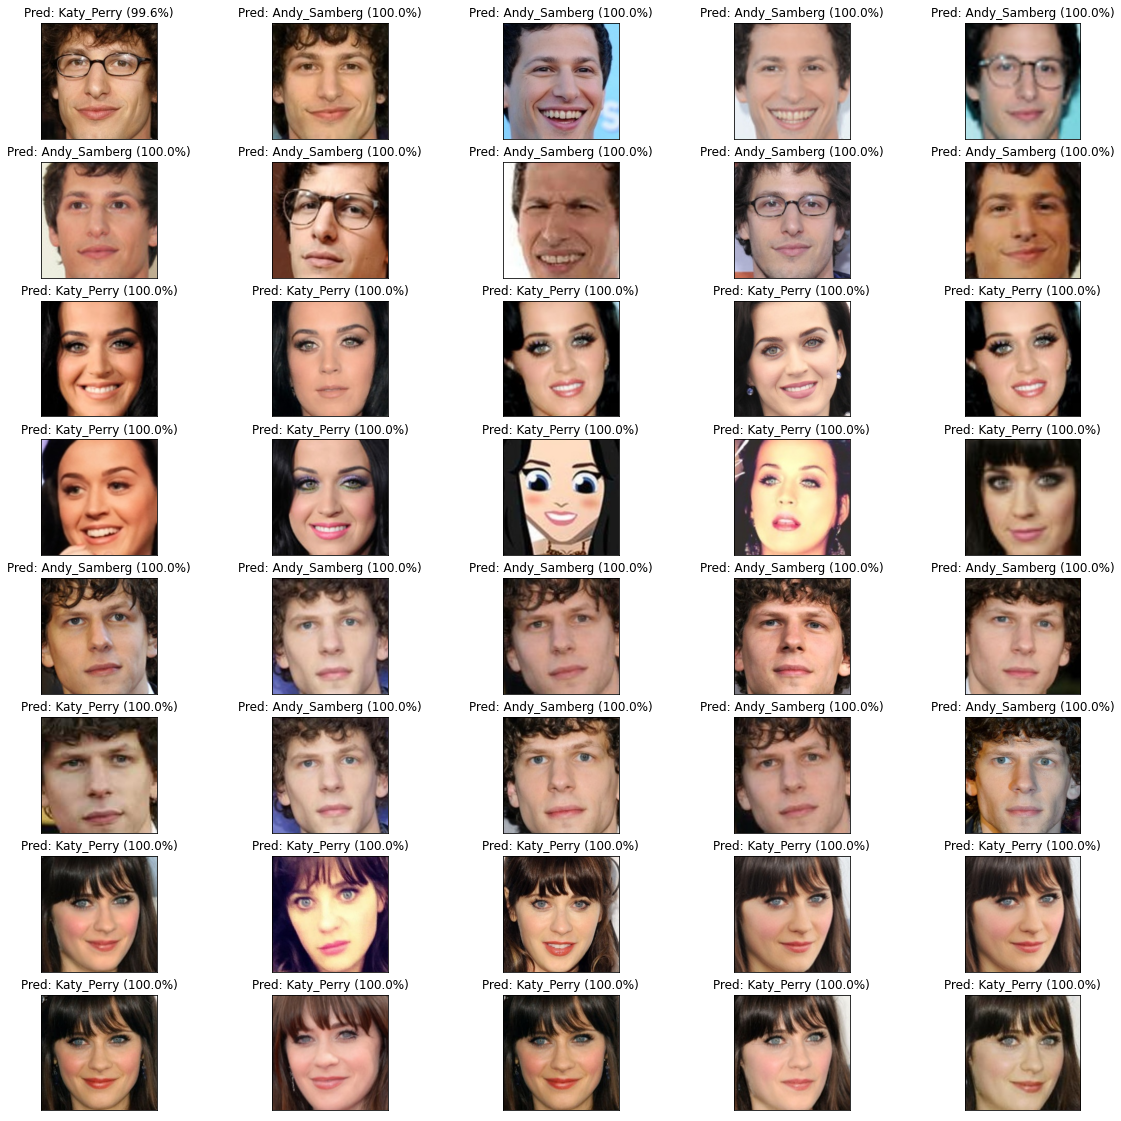

In [98]:
rows = 8
cols = 5
count = 0
fig = plt.figure(figsize=(20,20))
for i in range(0, rows):
  for j in range(0, cols):
    axs = plt.subplot(rows,cols, count+1)
    axs.set_xticks([])
    axs.set_yticks([])
    maxindex = np.argmax(classes[count])
    axs.imshow(cv2.cvtColor(X_test[count],cv2.COLOR_BGR2RGB))
    axs.set_title("Pred: {}".format(subjects[maxindex].split('.')[0])+' (%.1f' % (classes[count][maxindex]*100)+'%)')
    count += 1

plt.show()

We have seen how transfer learning works and we were successfully able to train and classify the persons in our datasets. Till now, our model was like a black box for us. We gave some input and we got the output correctly with the classification probability. We haven't looked into what is actually happening between the input and output layers. We don't know what the model has learnt or how the model is able to classify the persons in those images. To answer these questions, we need to look into the sections between the input and outputs.

By now, we know that the deep learning model is a stacking of convolution layers. The input images pass through these layers and undergo many transformations and filtering. The convolution layer performs some operations on the images and send out some output known as features. Each convolution layer outputs different features. All these features consitute to a **feature map**  at the end of a fully connected layer. Our deep learning model learns these features to predict the output on a new image. The convolution layers give out these features with the help of convolution filters. 

These filters are nothing but weights which are learned during the training by means of forward and backpropogation. These filters are responsible for the features that our model learns. 

The below lines of code shows the plots of some filters in the first convolution layers

In [78]:
for i in range(len(vgg_model.layers)):
  layer = vgg_model.layers[i]
	# check for convolutional layer
  if 'conv' not in layer.name:
    continue
  filters, biases = layer.get_weights()
  print(i, layer.name, filters.shape)


1 conv1_1 (3, 3, 3, 64)
2 conv1_2 (3, 3, 64, 64)
4 conv2_1 (3, 3, 64, 128)
5 conv2_2 (3, 3, 128, 128)
7 conv3_1 (3, 3, 128, 256)
8 conv3_2 (3, 3, 256, 256)
9 conv3_3 (3, 3, 256, 256)
11 conv4_1 (3, 3, 256, 512)
12 conv4_2 (3, 3, 512, 512)
13 conv4_3 (3, 3, 512, 512)
15 conv5_1 (3, 3, 512, 512)
16 conv5_2 (3, 3, 512, 512)
17 conv5_3 (3, 3, 512, 512)


From the above prints, we know the ID's of the convolution layers of our VGG Model. We can select any one of the ID corresponding to a conv net and see the learned filters in the below. For the purpose of demonstration, here we are choosing the ID as 5 i.e., conv2_2 (3,3,128,128) layer. You can choose a different ID and the corresponding filters and the feature map output of that layer will be displayed

In [81]:
#Change this parameter to select a different conv layer. The ID's can be choosen are only as above or from [1 2 4 5 7 8 9 11 12 13 15 16 17]
convID = 5

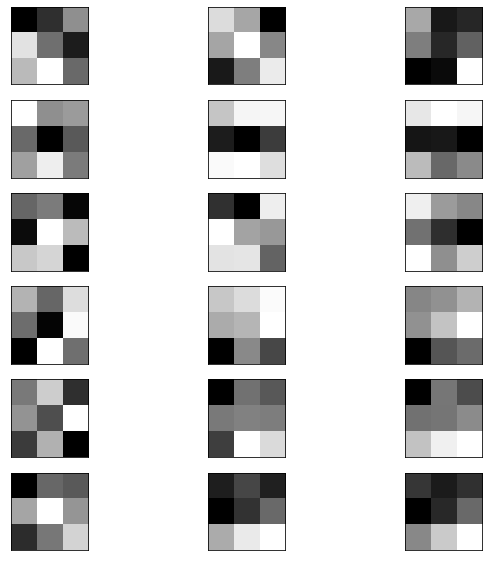

In [80]:
filters, biases = vgg_model.layers[convID].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
fig = plt.figure( figsize=(10,10) )
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()



In [82]:
# summarize feature map shapes
for i in range(len(vgg_model.layers)):
	layer = vgg_model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)


1 conv1_1 (?, 224, 224, 64)
2 conv1_2 (?, 224, 224, 64)
4 conv2_1 (?, 112, 112, 128)
5 conv2_2 (?, 112, 112, 128)
7 conv3_1 (?, 56, 56, 256)
8 conv3_2 (?, 56, 56, 256)
9 conv3_3 (?, 56, 56, 256)
11 conv4_1 (?, 28, 28, 512)
12 conv4_2 (?, 28, 28, 512)
13 conv4_3 (?, 28, 28, 512)
15 conv5_1 (?, 14, 14, 512)
16 conv5_2 (?, 14, 14, 512)
17 conv5_3 (?, 14, 14, 512)


Now from the selected conv layer, we generate a feature map with the data set. We create a small model from our original VGG model as below. The input layers is kept the same till the selected conv layer. The selected conv layer is made the output layer. We then use the in-build predict function to generate the feature map and the image features are plotted as below.

In [83]:
fMapModel = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[convID].output)
feature_maps = fMapModel.predict(X_train_tl)

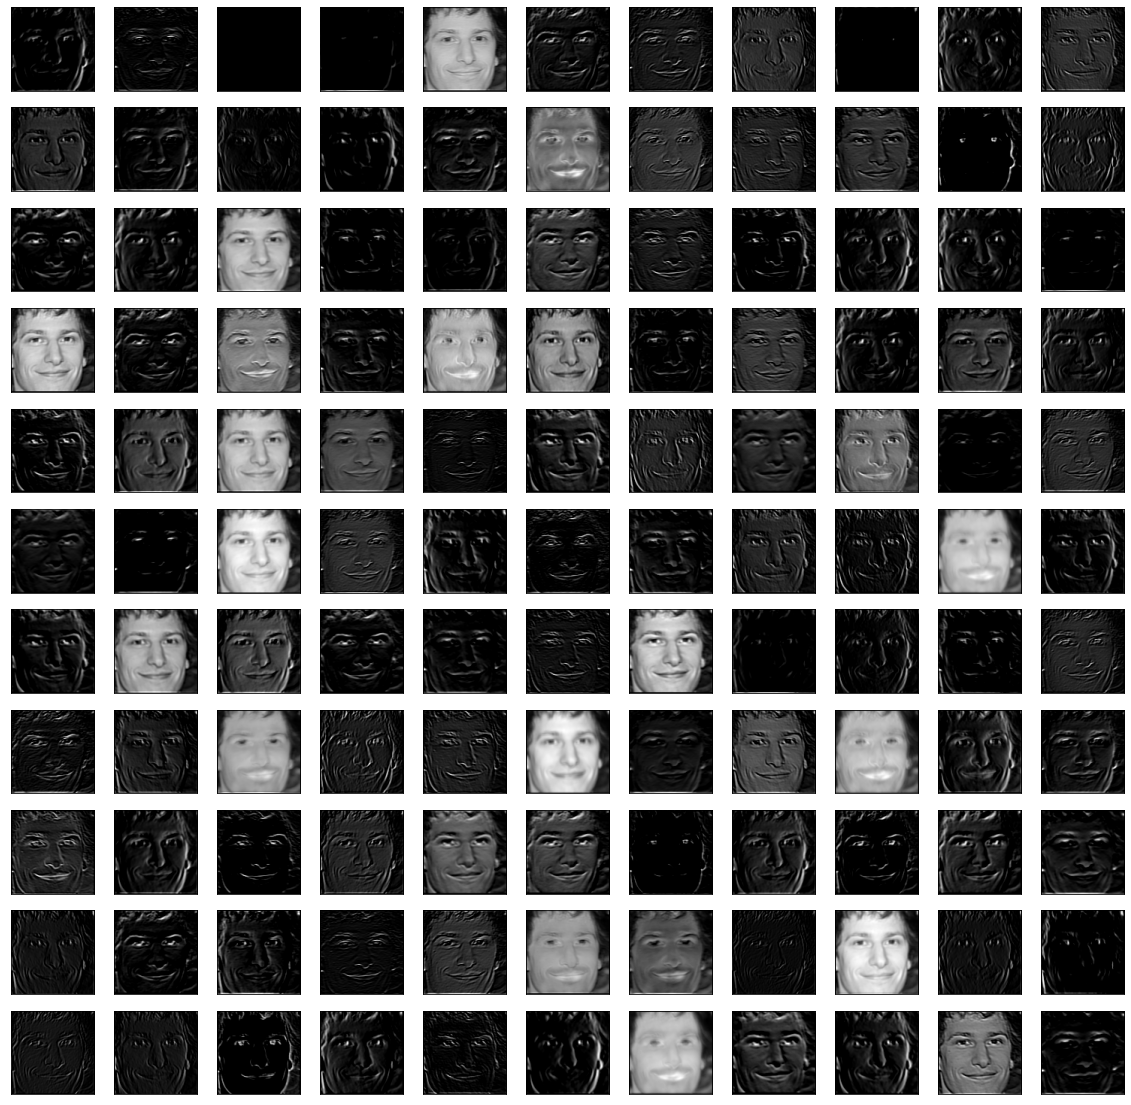

In [84]:
square = 11
ix = 1
fig = plt.figure( figsize=(20,20) )
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[1, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
plt.show()

As discussed above, the feature maps for each convolution layer can be extracted. We will now visualize the above feature map extracted from transfer learning using tSNE.

###**T-Distributed Stochastic Neighbouring Entities (t-SNE) :**

Just like PCA, t-Distributed Stochastic Neighbor Embedding (t-SNE) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. Contrary to PCA it is not a mathematical technique but a probablistic one. The original paper http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf describes the working of t-SNE as:

*“t-Distributed stochastic neighbor embedding (t-SNE) minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding”.*

**PCA** is a linear feature extraction technique. It performs a linear mapping of the data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximized.

In simpler terms, PCA combines the input features in a specific way that we can drop the least important feature while still retaining the most valuable parts of all of the features. Each of the new features or components created after PCA are all independent of one another.

**t-Distributed Stochastic Neighbor Embedding (t-SNE)** on the other hand is a non-linear technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets.

The algorithms starts by calculating the probability of similarity of points in high-dimensional space and calculating the probability of similarity of points in the corresponding low-dimensional space. The similarity of points is calculated as the conditional probability that a point A would choose point B as its neighbor if neighbors were picked in proportion to their probability density under a Gaussian (normal distribution) centered at A.
It then tries to minimize the difference between these conditional probabilities (or similarities) in higher-dimensional and lower-dimensional space for a perfect representation of data points in lower-dimensional space.

In simpler terms, t-Distributed stochastic neighbor embedding (t-SNE) minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding.

In this way, t-SNE maps the multi-dimensional data to a lower dimensional space and attempts to find patterns in the data by identifying observed clusters based on similarity of data points with multiple features. However, after this process, the input features are no longer identifiable, and we cannot make any inference based only on the output of t-SNE. Hence it is mainly a data exploration and visualization technique.

More information is available here : https://www.datacamp.com/community/tutorials/introduction-t-sne

In [85]:
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
%matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


In [86]:
#Color corresponding to image class
colors_per_class = {
    'Andy_Samberg' : [254, 202, 87],
    'Katy_Perry' : [0, 0, 255],
}

The below functions visualize the images features as scatter plots and scatter images.

In [87]:
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range


def scale_image(image, max_image_size):
    image_height, image_width, _ = image.shape

    scale = max(1, image_width / max_image_size, image_height / max_image_size)
    image_width = int(image_width / scale)
    image_height = int(image_height / scale)

    image = cv2.resize(image, (image_width, image_height))
    return image


def draw_rectangle_by_class(image, label):
    image_height, image_width, _ = image.shape

    # get the color corresponding to image class
    color = colors_per_class[label]
    image = cv2.rectangle(image, (0, 0), (image_width - 1, image_height - 1), color=color, thickness=5)

    return image


def compute_plot_coordinates(image, x, y, image_centers_area_size, offset):
    image_height, image_width, _ = image.shape

    # compute the image center coordinates on the plot
    center_x = int(image_centers_area_size * x) + offset

    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int(image_centers_area_size * (1 - y)) + offset

    # knowing the image center, compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)

    br_x = tl_x + image_width
    br_y = tl_y + image_height

    return tl_x, tl_y, br_x, br_y

In [88]:
def visualize_tsne_points(tx, ty, labels):
    # initialize matplotlib plot
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # for every class, we'll add a scatter plot separately
    for label in colors_per_class:
        # find the samples of the current class in the data
        indices = [i for i, l in enumerate(labels) if l == label]

        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)

        # convert the class color to matplotlib format:
        # BGR -> RGB, divide by 255, convert to np.array
        color = np.array([colors_per_class[label][::-1]], dtype=np.float) / 255

        # add a scatter plot with the correponding color and label
        ax.scatter(current_tx, current_ty, c=color, label=label)

    # build a legend using the labels we set previously
    ax.legend(loc='best')

    # finally, show the plot
    plt.show()

In [89]:
def visualize_tsne_images(tx, ty, images, labels, plot_size=1000, max_image_size=100):
    # we'll put the image centers in the central area of the plot
    # and use offsets to make sure the images fit the plot
    offset = max_image_size // 2
    image_centers_area_size = plot_size - 2 * offset

    tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8)

    # now we'll put a small copy of every image to its corresponding T-SNE coordinate
    for image_path, label, x, y in tqdm(
            zip(images, labels, tx, ty),
            desc='Building the T-SNE plot',
            total=len(images)
    ):
        image = cv2.imread(image_path)

        # scale the image to put it to the plot
        image = scale_image(image, max_image_size)

        # draw a rectangle with a color corresponding to the image class
        image = draw_rectangle_by_class(image, label)

        # compute the coordinates of the image on the scaled plot visualization
        tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size, offset)

        # put the image to its TSNE coordinates using numpy subarray indices
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image

    plt.imshow(tsne_plot[:, :, ::-1])
    plt.show()

In [90]:
def visualize_tsne(tsne, images, labels, plot_size=1000, max_image_size=100):
    # extract x and y coordinates representing the positions of the images on T-SNE plot
    tx = tsne[:, 0]
    ty = tsne[:, 1]

    # scale and move the coordinates so they fit [0; 1] range
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)

    # visualize the plot: samples as colored points
    visualize_tsne_points(tx, ty, labels)

    # visualize the plot: samples as images
    visualize_tsne_images(tx, ty, images, labels, plot_size=plot_size, max_image_size=max_image_size)

In [91]:
a,b,c,d = feature_maps.shape
image_features = []
for im in feature_maps:
  _,_,length = im.shape
  imag = []
  for j in range(length):
    imag = (im[:,:,j])
    imag = cv2.resize(imag,(50,50))
    imag = imag.flatten()
    image_features.append(imag)
images_scaled = StandardScaler().fit_transform(image_features)
label_to_id_dict = {v:i for i,v in enumerate(np.unique(Y_train_tl))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}
label_ids = np.array([label_to_id_dict[x] for x in Y_train_new])

In [92]:
feature_maps_ = feature_maps.reshape(a,b*c*d) #Reshaping the feature maps compatible with the dimensions of TSNE


We use the inbuilt function TSNE available in the scikit learn package.
Internally, t-SNE uses an iterative approach with a default iterations steps 1000, making small (or sometimes large) adjustments to the points. In practice, it often terminates early if it  finds a locally optimal (good enough) embedding.

* n_components is the number of dimensions to project down to. In principle it can be anything, but in practice t-SNE is almost always used to project to 2 or 3 dimensions for visualization purposes. For our case, we use n_components as 2

* learning_rate is the step size for iterations.

* perplexity refers to the number of independent clusters or zones t-SNE will attempt to fit points around. It is relatively robust to large changes, and usually a value between 20-50 works best.

* angle controls the speed vs accuracy tradeoff. Lower angle means better accuracy but slower, although in practice, there is usually little improvement below a certain threshold.


In [93]:
time_start = time.time()
tsne = TSNE(n_components=2, learning_rate = 200.0, perplexity=40)
#tsne_results = tsne.fit_transform(featureMapOut[0].reshape(len(featureMapOut[0]),1))
tsne_results = tsne.fit_transform(feature_maps_)
tsne_result_scaled = StandardScaler().fit_transform(tsne_results)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 1.947650671005249 seconds
t-SNE done! Time elapsed: 1.9480466842651367 seconds


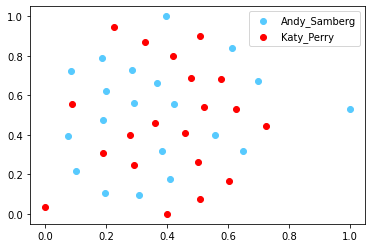

Building the T-SNE plot: 100%|██████████| 40/40 [00:00<00:00, 932.50it/s]


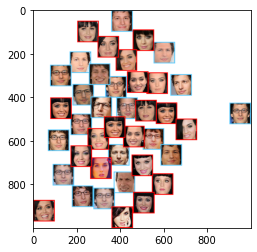

In [94]:
visualize_tsne(tsne_result_scaled, Train_img_dir, imageLabels)

Similar to Visualizing transfer learnign features on t-SNE, we can do the same with PCA. It is always a good idea to first run the image vectors through a faster dimensionality reduction technique like PCA to project our data into an intermediate lower-dimensional space before using t-SNE. This improves accuracy, and cuts down on runtime since PCA is more efficient than t-SNE. 

In [95]:
image_pca = []
for image in X_train_new:
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image, (50,50))
  image = image.flatten()
  image_pca.append(image)
image_pca_ = np.array(image_pca) 
pca_scaled = StandardScaler().fit_transform(image_pca_)

In [96]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_scaled)
tsne = TSNE(n_components=2, perplexity=40.0)
tsne_pca_result = tsne.fit_transform(pca_result)
tsne_pca_result_scaled = StandardScaler().fit_transform(tsne_pca_result)

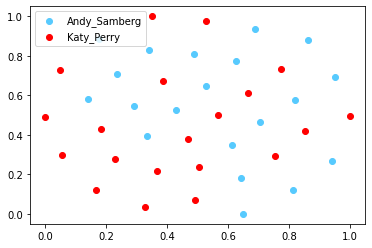

Building the T-SNE plot: 100%|██████████| 40/40 [00:00<00:00, 924.65it/s]


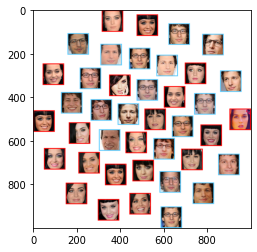

In [97]:
visualize_tsne(tsne_pca_result_scaled, Train_img_dir, imageLabels)
